!pip install git+https://github.com/CC-RMD-EpiBio/autoencirt.git

In [1]:
%matplotlib inline
import numpy as np
import sys
sys.path.append('../bayesianquilts')
import json
import matplotlib.pyplot as plt


In [2]:
from factor_analyzer import FactorAnalyzer

In [3]:
import tensorflow as tf
import autoencirt
from autoencirt.irt import GRModel, FactorizedGRModel
from autoencirt.data.rwa import item_text, get_data, to_reverse

dim = 2

In [4]:
pd_data = get_data(reorient=True, pandas=True)
responses = pd_data[0].iloc[:, :22]
fa = FactorAnalyzer(n_factors=dim)
fa.fit(responses)
loadings = fa.loadings_
loadings.shape


(22, 2)

In [5]:
pd_data[0].describe()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q14,Q15,Q16,Q17,Q18,Q19,Q20,Q21,Q22,person
count,9881.000000,9881.000000,9881.000000,9881.000000,9881.000000,9881.000000,9881.00000,9881.000000,9881.000000,9881.000000,...,9881.000000,9881.000000,9881.000000,9881.000000,9881.000000,9881.000000,9881.000000,9881.000000,9881.000000,9881.000000
mean,2.383463,1.105556,1.723307,1.436191,1.953142,1.544682,1.86641,2.314037,1.461492,2.207165,...,2.545188,2.145835,1.139864,1.997875,1.129744,1.809027,1.439024,2.719664,1.896164,4940.000000
std,2.187470,2.082531,2.542981,2.382205,2.117866,2.280318,2.53573,2.410221,1.996039,2.639795,...,2.738134,2.309873,2.091691,2.554249,2.093746,2.313021,2.040717,2.673257,2.493584,2852.543339
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2470.000000
50%,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.00000,2.000000,1.000000,1.000000,...,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,2.000000,1.000000,4940.000000
75%,4.000000,1.000000,2.000000,2.000000,3.000000,2.000000,3.00000,4.000000,2.000000,4.000000,...,5.000000,3.000000,1.000000,4.000000,1.000000,3.000000,2.000000,4.000000,3.000000,7410.000000
max,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.00000,8.000000,8.000000,8.000000,...,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,9880.000000


In [6]:
tfdata, num_people = get_data(reorient=True)
item_names = [f"Q{j}" for j in range(1, 23)]
scale_indices = [
    [1, 3, 5, 7, 8, 10, 12, 14, 15, 17, 19, 20],
    [0, 2, 4, 6, 9, 11, 13, 16, 18, 21],
]
fgrm = FactorizedGRModel(
    data=tfdata,
    item_keys=item_names,
    num_people=num_people,
    dim=dim,
    eta_scale=1e-3,
    kappa_scale=1e-3,
    weight_exponent=1,
    response_cardinality=9,
    scale_indices=scale_indices,
    discrimination_guess=0.5*tf.cast(np.abs(loadings).T, tf.float64)[
        tf.newaxis, :, :, tf.newaxis
    ],
)

grm = GRModel(
    data=tfdata,
    item_keys=item_names,
    num_people=num_people,
    dim=dim,
    eta_scale=1e-3,
    kappa_scale=1e-3,
    weight_exponent=1,
    response_cardinality=9,
    discrimination_guess=0.5*tf.cast(np.abs(loadings).T, tf.float64)[
        tf.newaxis, :, :, tf.newaxis
    ],
)

batch_size = 241


def data_factory_factory(batch_size=batch_size, repeat=False, shuffle=False):
    def data_factory(batch_size=batch_size):
        if shuffle:
            out = tfdata.shuffle(batch_size * 10)
        else:
            out = tfdata

        if repeat:
            out = out.repeat()
        return out.batch(batch_size)

    return data_factory

In [7]:
losses = grm.fit(
            data_factory_factory(shuffle=True, repeat=True),
            dataset_size=num_people,
            batches_per_step=1,
            check_every=int(num_people/batch_size),
            batch_size=batch_size,
            num_steps=10000,
            max_decay_steps=100,
            max_plateau_epochs=100,
            sample_size=32, 
            learning_rate=0.0015)

Running optimization for 10000 steps of 1 accumulated batches, checking every 41 steps
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1-1


  0%|          | 40/10000 [00:08<24:29,  6.78it/s] 

Step 41: average-batch loss:369113.51782159245 rel loss: 2.709193653761932e+302
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1-2


  1%|          | 81/10000 [00:14<25:25,  6.50it/s]

Step 82: average-batch loss:383286.10663302825 rel loss: 0.03697652632372907
New learning rate: 0.001485


  1%|          | 122/10000 [00:20<22:09,  7.43it/s]

Step 123: average-batch loss:335971.17944334203 rel loss: 0.09864637327869229
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1-3


  2%|▏         | 163/10000 [00:26<22:57,  7.14it/s]

Step 164: average-batch loss:350596.6247619817 rel loss: 0.041715875983029865
New learning rate: 0.00147015


  2%|▏         | 204/10000 [00:31<22:36,  7.22it/s]

Step 205: average-batch loss:350986.2490609522 rel loss: 0.04277965207406936
New learning rate: 0.0014554485


  2%|▏         | 245/10000 [00:37<22:08,  7.34it/s]

Step 246: average-batch loss:339812.1485052716 rel loss: 0.01130321290402592
New learning rate: 0.001440894015


  3%|▎         | 286/10000 [00:43<23:16,  6.96it/s]

Step 287: average-batch loss:290440.15278881614 rel loss: 0.15676560633003198
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1-4


  3%|▎         | 327/10000 [00:49<23:04,  6.98it/s]

Step 328: average-batch loss:293459.1599227428 rel loss: 0.010287656840295829
New learning rate: 0.0014264850748499998


  4%|▎         | 368/10000 [00:55<22:32,  7.12it/s]

Step 369: average-batch loss:311702.7148233844 rel loss: 0.06821423434382334
New learning rate: 0.0014122202241015


  4%|▍         | 409/10000 [01:01<22:44,  7.03it/s]

Step 410: average-batch loss:285698.92203086766 rel loss: 0.016595200024717705
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1-5


  4%|▍         | 450/10000 [01:06<22:03,  7.22it/s]

Step 451: average-batch loss:293735.9183924782 rel loss: 0.0273612992431924
New learning rate: 0.001398098021860485


  5%|▍         | 491/10000 [01:12<22:26,  7.06it/s]

Step 492: average-batch loss:239230.04654338965 rel loss: 0.1942434746759532
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1-6


  5%|▌         | 532/10000 [01:18<21:29,  7.34it/s]

Step 533: average-batch loss:262079.44626849302 rel loss: 0.08718501221837445
New learning rate: 0.00138411704164188


  6%|▌         | 573/10000 [01:24<22:17,  7.05it/s]

Step 574: average-batch loss:237025.50101762277 rel loss: 0.009300879088123826
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1-7


  6%|▌         | 614/10000 [01:30<21:32,  7.26it/s]

Step 615: average-batch loss:207417.85810848768 rel loss: 0.14274394297162749
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1-8


  7%|▋         | 655/10000 [01:36<22:19,  6.98it/s]

Step 656: average-batch loss:229376.80867083895 rel loss: 0.09573308953767366
New learning rate: 0.0013702758712254614


  7%|▋         | 696/10000 [01:42<22:08,  7.00it/s]

Step 697: average-batch loss:177047.17366249248 rel loss: 0.17154006933706414
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1-9


  7%|▋         | 737/10000 [01:47<21:32,  7.17it/s]

Step 738: average-batch loss:203544.36369617982 rel loss: 0.1301789425780334
New learning rate: 0.0013565731125132067


  8%|▊         | 778/10000 [01:53<21:27,  7.16it/s]

Step 779: average-batch loss:184602.3329434882 rel loss: 0.0409266728135476
New learning rate: 0.0013430073813880746


  8%|▊         | 819/10000 [01:59<21:31,  7.11it/s]

Step 820: average-batch loss:175904.40174514105 rel loss: 0.006496551001646556
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1-10


  9%|▊         | 860/10000 [02:05<21:49,  6.98it/s]

Step 861: average-batch loss:163182.5464511812 rel loss: 0.07796088227956291
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1-11


  9%|▉         | 901/10000 [02:11<20:49,  7.28it/s]

Step 902: average-batch loss:130521.8647063048 rel loss: 0.2502314981353369
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1-12


  9%|▉         | 942/10000 [02:16<21:27,  7.03it/s]

Step 943: average-batch loss:161483.22989440087 rel loss: 0.19173114885268713
New learning rate: 0.001329577307574194


 10%|▉         | 983/10000 [02:22<20:40,  7.27it/s]

Step 984: average-batch loss:155503.89253556976 rel loss: 0.1606521060143276
New learning rate: 0.0013162815344984519


 10%|█         | 1024/10000 [02:28<20:49,  7.18it/s]

Step 1025: average-batch loss:141427.9700559269 rel loss: 0.07711420410905534
New learning rate: 0.0013031187191534673


 11%|█         | 1065/10000 [02:34<20:21,  7.32it/s]

Step 1066: average-batch loss:171280.3289163843 rel loss: 0.2379634863381012
New learning rate: 0.0012900875319619327


 11%|█         | 1106/10000 [02:40<20:34,  7.21it/s]

Step 1107: average-batch loss:140909.99797389572 rel loss: 0.07372176152834362
New learning rate: 0.0012771866566423133
We are in a loss plateau
Restoring from a checkpoint


 11%|█▏        | 1147/10000 [02:45<21:03,  7.01it/s]

Step 1148: average-batch loss:149984.31396487268 rel loss: 0.12976323152783908
New learning rate: 0.00126441479007589
We are in a loss plateau
Restoring from a checkpoint


 12%|█▏        | 1188/10000 [02:51<20:48,  7.06it/s]

Step 1189: average-batch loss:113493.46470980978 rel loss: 0.15003859508593514
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1-13


 12%|█▏        | 1229/10000 [02:57<21:10,  6.90it/s]

Step 1230: average-batch loss:138067.8522104551 rel loss: 0.1779877582450323
New learning rate: 0.0012517706421751314


 13%|█▎        | 1270/10000 [03:03<20:48,  6.99it/s]

Step 1271: average-batch loss:154580.49993750092 rel loss: 0.2657970134933139
New learning rate: 0.00123925293575338


 13%|█▎        | 1311/10000 [03:09<20:11,  7.17it/s]

Step 1312: average-batch loss:114557.43084657709 rel loss: 0.009287622190063294
New learning rate: 0.0012268604063958462


 14%|█▎        | 1352/10000 [03:15<20:10,  7.14it/s]

Step 1353: average-batch loss:128049.43418892995 rel loss: 0.11367460989826506
New learning rate: 0.0012145918023318877


 14%|█▍        | 1393/10000 [03:20<20:11,  7.11it/s]

Step 1394: average-batch loss:113237.24788061072 rel loss: 0.0022626550361696325
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1-14


 14%|█▍        | 1434/10000 [03:26<20:19,  7.03it/s]

Step 1435: average-batch loss:89678.36901752434 rel loss: 0.262704140599197
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1-15


 15%|█▍        | 1475/10000 [03:32<20:10,  7.04it/s]

Step 1476: average-batch loss:105024.641016775 rel loss: 0.1461206803534752
New learning rate: 0.0012024458843085688


 15%|█▌        | 1516/10000 [03:38<20:04,  7.05it/s]

Step 1517: average-batch loss:107162.52484722118 rel loss: 0.16315550473100132
New learning rate: 0.001190421425465483


 16%|█▌        | 1557/10000 [03:44<19:52,  7.08it/s]

Step 1558: average-batch loss:82197.84848979447 rel loss: 0.0910062813707178
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1-16


 16%|█▌        | 1598/10000 [03:50<19:43,  7.10it/s]

Step 1599: average-batch loss:58654.21794653364 rel loss: 0.4013970583449271
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1-17


 16%|█▋        | 1639/10000 [03:55<19:36,  7.11it/s]

Step 1640: average-batch loss:76718.12505409043 rel loss: 0.23545814101714244
New learning rate: 0.0011785172112108281


 17%|█▋        | 1680/10000 [04:01<19:03,  7.28it/s]

Step 1681: average-batch loss:69417.85600250497 rel loss: 0.15505575475541797
New learning rate: 0.00116673203909872


 17%|█▋        | 1721/10000 [04:07<19:46,  6.98it/s]

Step 1722: average-batch loss:63705.804332656815 rel loss: 0.07929554361710864
New learning rate: 0.0011550647187077326


 18%|█▊        | 1762/10000 [04:13<19:15,  7.13it/s]

Step 1763: average-batch loss:56709.43729183488 rel loss: 0.0342937745033624
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1-18


 18%|█▊        | 1803/10000 [04:19<19:49,  6.89it/s]

Step 1804: average-batch loss:88185.76522111666 rel loss: 0.35693207231754637
New learning rate: 0.0011435140715206553


 18%|█▊        | 1844/10000 [04:25<19:50,  6.85it/s]

Step 1845: average-batch loss:76329.98471257577 rel loss: 0.2570490154638836
New learning rate: 0.001132078930805449


 19%|█▉        | 1885/10000 [04:31<19:20,  6.99it/s]

Step 1886: average-batch loss:66821.50305483057 rel loss: 0.15132951670809022
New learning rate: 0.0011207581414973942


 19%|█▉        | 1926/10000 [04:36<19:02,  7.06it/s]

Step 1927: average-batch loss:66351.99497283972 rel loss: 0.1453243069021796
New learning rate: 0.0011095505600824203


 20%|█▉        | 1967/10000 [04:42<18:16,  7.33it/s]

Step 1968: average-batch loss:50456.96826085041 rel loss: 0.12391685918703459
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1-19


 20%|██        | 2008/10000 [04:48<19:01,  7.00it/s]

Step 2009: average-batch loss:63477.698821459526 rel loss: 0.2051229140683228
New learning rate: 0.0010984550544815962


 20%|██        | 2049/10000 [04:54<19:03,  6.95it/s]

Step 2050: average-batch loss:52215.16097901882 rel loss: 0.03367207311445223
New learning rate: 0.00108747050393678


 21%|██        | 2090/10000 [05:00<18:43,  7.04it/s]

Step 2091: average-batch loss:46143.85271982332 rel loss: 0.09347107549114946
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1-20


 21%|██▏       | 2131/10000 [05:06<18:51,  6.95it/s]

Step 2132: average-batch loss:66170.23246713432 rel loss: 0.30264937874077713
New learning rate: 0.0010765957988974125


 22%|██▏       | 2172/10000 [05:12<18:25,  7.08it/s]

Step 2173: average-batch loss:38810.75495711251 rel loss: 0.18894499142864352
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1-21


 22%|██▏       | 2213/10000 [05:18<18:21,  7.07it/s]

Step 2214: average-batch loss:51692.67305703896 rel loss: 0.24920201138974232
New learning rate: 0.001065829840908438


 23%|██▎       | 2254/10000 [05:23<17:57,  7.19it/s]

Step 2255: average-batch loss:30152.97132036923 rel loss: 0.28712870598244133
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1-22


 23%|██▎       | 2295/10000 [05:29<18:03,  7.11it/s]

Step 2296: average-batch loss:48249.329400365204 rel loss: 0.37505926620938695
New learning rate: 0.0010551715424993537


 23%|██▎       | 2336/10000 [05:35<17:50,  7.16it/s]

Step 2337: average-batch loss:38999.83116394619 rel loss: 0.22684354212680627
New learning rate: 0.0010446198270743603


 24%|██▍       | 2377/10000 [05:41<17:38,  7.20it/s]

Step 2378: average-batch loss:28993.758959778006 rel loss: 0.03998144435839993
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1-23


 24%|██▍       | 2418/10000 [05:46<17:42,  7.14it/s]

Step 2419: average-batch loss:45234.701768732564 rel loss: 0.35903724737676357
New learning rate: 0.0010341736288036166


 25%|██▍       | 2459/10000 [05:52<17:43,  7.09it/s]

Step 2460: average-batch loss:35544.54320221374 rel loss: 0.1842978880096494
New learning rate: 0.0010238318925155805


 25%|██▌       | 2500/10000 [05:58<16:57,  7.37it/s]

Step 2501: average-batch loss:24498.69312744305 rel loss: 0.18348186203041394
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1-24


 25%|██▌       | 2541/10000 [06:03<16:45,  7.42it/s]

Step 2542: average-batch loss:23875.214821644164 rel loss: 0.026114039620438078
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1-25


 26%|██▌       | 2582/10000 [06:09<17:19,  7.14it/s]

Step 2583: average-batch loss:27722.89208701399 rel loss: 0.13879061583088442
New learning rate: 0.0010135935735904246


 26%|██▌       | 2623/10000 [06:15<16:06,  7.63it/s]

Step 2624: average-batch loss:29070.33969345031 rel loss: 0.17870877762658666
New learning rate: 0.0010034576378545204


 27%|██▋       | 2664/10000 [06:21<17:45,  6.88it/s]

Step 2665: average-batch loss:19419.07733006694 rel loss: 0.22947215337969223
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1-26


 27%|██▋       | 2705/10000 [06:27<18:14,  6.66it/s]

Step 2706: average-batch loss:24959.95903127228 rel loss: 0.221990817142896
New learning rate: 0.0009934230614759751


 27%|██▋       | 2746/10000 [06:33<17:23,  6.95it/s]

Step 2747: average-batch loss:22619.21590644105 rel loss: 0.14147875813249747
New learning rate: 0.0009834888308612154


 28%|██▊       | 2787/10000 [06:38<16:38,  7.22it/s]

Step 2788: average-batch loss:44789.59290087615 rel loss: 0.5664377353676043
New learning rate: 0.0009736539425526032


 28%|██▊       | 2828/10000 [06:44<16:38,  7.18it/s]

Step 2829: average-batch loss:35479.292658548264 rel loss: 0.45266447341677285
New learning rate: 0.0009639174031270772


 29%|██▊       | 2869/10000 [06:50<17:06,  6.94it/s]

Step 2870: average-batch loss:23717.148575422198 rel loss: 0.1812220904923326
New learning rate: 0.0009542782290958064
We are in a loss plateau
Restoring from a checkpoint


 29%|██▉       | 2910/10000 [06:56<16:51,  7.01it/s]

Step 2911: average-batch loss:23749.385511980643 rel loss: 0.18233348310124622
New learning rate: 0.0009447354468048484
We are in a loss plateau
Restoring from a checkpoint


 30%|██▉       | 2951/10000 [07:02<17:06,  6.87it/s]

Step 2952: average-batch loss:26952.91092472968 rel loss: 0.27951836503679245
New learning rate: 0.0009352880923367999
We are in a loss plateau
Restoring from a checkpoint


 30%|██▉       | 2992/10000 [07:07<16:17,  7.17it/s]

Step 2993: average-batch loss:11782.861673347827 rel loss: 0.6480781891882686
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1-27


 30%|███       | 3033/10000 [07:13<16:30,  7.04it/s]

Step 3034: average-batch loss:16619.55005250932 rel loss: 0.2910240267564416
New learning rate: 0.0009259352114134319


 31%|███       | 3074/10000 [07:19<16:07,  7.16it/s]

Step 3075: average-batch loss:18484.97954215326 rel loss: 0.362571019000691
New learning rate: 0.0009166758592992976


 31%|███       | 3115/10000 [07:25<16:10,  7.10it/s]

Step 3116: average-batch loss:20850.78924800585 rel loss: 0.43489613111528963
New learning rate: 0.0009075091007063045


 32%|███▏      | 3156/10000 [07:31<16:21,  6.97it/s]

Step 3157: average-batch loss:20231.142983542748 rel loss: 0.41758793939953226
New learning rate: 0.0008984340096992414


 32%|███▏      | 3197/10000 [07:37<16:05,  7.04it/s]

Step 3198: average-batch loss:26256.475157955952 rel loss: 0.5512397759995019
New learning rate: 0.0008894496696022491
We are in a loss plateau
Restoring from a checkpoint


 32%|███▏      | 3238/10000 [07:42<15:39,  7.20it/s]

Step 3239: average-batch loss:20522.14658679325 rel loss: 0.4258465300637445
New learning rate: 0.0008805551729062267
We are in a loss plateau
Restoring from a checkpoint


 33%|███▎      | 3279/10000 [07:48<15:41,  7.14it/s]

Step 3280: average-batch loss:15551.895951257062 rel loss: 0.24235207653923274
New learning rate: 0.0008717496211771643
We are in a loss plateau
Restoring from a checkpoint


 33%|███▎      | 3320/10000 [07:54<15:46,  7.06it/s]

Step 3321: average-batch loss:17198.319157621532 rel loss: 0.31488295074892914
New learning rate: 0.0008630321249653928
We are in a loss plateau
Restoring from a checkpoint


 34%|███▎      | 3361/10000 [08:00<15:38,  7.08it/s]

Step 3362: average-batch loss:21568.876513409446 rel loss: 0.45370999430487813
New learning rate: 0.0008544018037157388
We are in a loss plateau
Restoring from a checkpoint


 34%|███▍      | 3402/10000 [08:06<15:32,  7.07it/s]

Step 3403: average-batch loss:15047.927835758352 rel loss: 0.21697779242745682
New learning rate: 0.0008458577856785813
We are in a loss plateau
Restoring from a checkpoint


 34%|███▍      | 3443/10000 [08:12<15:34,  7.02it/s]

Step 3444: average-batch loss:18422.002240926115 rel loss: 0.3603919096714063
New learning rate: 0.0008373992078217955
We are in a loss plateau
Restoring from a checkpoint


 35%|███▍      | 3484/10000 [08:18<15:15,  7.12it/s]

Step 3485: average-batch loss:19602.33652260929 rel loss: 0.39890524480296
New learning rate: 0.0008290252157435777
We are in a loss plateau
Restoring from a checkpoint


 35%|███▌      | 3525/10000 [08:24<15:25,  7.00it/s]

Step 3526: average-batch loss:19384.208830003354 rel loss: 0.39214121263953655
New learning rate: 0.0008207349635861418
We are in a loss plateau
Restoring from a checkpoint


 36%|███▌      | 3566/10000 [08:30<15:24,  6.96it/s]

Step 3567: average-batch loss:16003.146659017004 rel loss: 0.26371594759404704
New learning rate: 0.0008125276139502803
We are in a loss plateau
Restoring from a checkpoint


 36%|███▌      | 3607/10000 [08:35<15:41,  6.79it/s]

Step 3608: average-batch loss:14312.27297782824 rel loss: 0.1767302306488168
New learning rate: 0.0008044023378107775
We are in a loss plateau
Restoring from a checkpoint


 36%|███▋      | 3648/10000 [08:41<15:02,  7.04it/s]

Step 3649: average-batch loss:12956.230416368597 rel loss: 0.09056405337916526
New learning rate: 0.0007963583144326697
We are in a loss plateau
Restoring from a checkpoint


 37%|███▋      | 3689/10000 [08:47<14:48,  7.11it/s]

Step 3690: average-batch loss:16092.70630867386 rel loss: 0.267813539417112
New learning rate: 0.000788394731288343
We are in a loss plateau
Restoring from a checkpoint


 37%|███▋      | 3730/10000 [08:53<14:46,  7.07it/s]

Step 3731: average-batch loss:16553.433497961 rel loss: 0.2881922850145136
New learning rate: 0.0007805107839754596
We are in a loss plateau
Restoring from a checkpoint


 38%|███▊      | 3771/10000 [08:59<15:00,  6.91it/s]

Step 3772: average-batch loss:12120.779592554343 rel loss: 0.027879223165983135
New learning rate: 0.000772705676135705
We are in a loss plateau
Restoring from a checkpoint


 38%|███▊      | 3812/10000 [09:05<14:53,  6.93it/s]

Step 3813: average-batch loss:15810.098285789336 rel loss: 0.2547255899137154
New learning rate: 0.000764978619374348
We are in a loss plateau
Restoring from a checkpoint


 39%|███▊      | 3853/10000 [09:11<14:46,  6.93it/s]

Step 3854: average-batch loss:21367.804817213444 rel loss: 0.44856938866009266
New learning rate: 0.0007573288331806045
We are in a loss plateau
Restoring from a checkpoint


 39%|███▉      | 3894/10000 [09:16<14:08,  7.20it/s]

Step 3895: average-batch loss:14020.638744955024 rel loss: 0.15960592896756615
New learning rate: 0.0007497555448487984
We are in a loss plateau
Restoring from a checkpoint


 39%|███▉      | 3935/10000 [09:22<14:17,  7.07it/s]

Step 3936: average-batch loss:17780.134489510776 rel loss: 0.33730188147344914
New learning rate: 0.0007422579894003105
We are in a loss plateau
Restoring from a checkpoint


 40%|███▉      | 3976/10000 [09:28<14:10,  7.08it/s]

Step 3977: average-batch loss:16991.692409931016 rel loss: 0.3065516142193594
New learning rate: 0.0007348354095063073
We are in a loss plateau
Restoring from a checkpoint


 40%|████      | 4017/10000 [09:34<14:04,  7.08it/s]

Step 4018: average-batch loss:14123.560070990061 rel loss: 0.16573005572795016
New learning rate: 0.0007274870554112442
We are in a loss plateau
Restoring from a checkpoint


 41%|████      | 4058/10000 [09:39<14:58,  6.61it/s]

Step 4059: average-batch loss:9433.310707966024 rel loss: 0.24906960431163452
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1-28


 41%|████      | 4099/10000 [09:45<14:04,  6.99it/s]

Step 4100: average-batch loss:11373.887400541866 rel loss: 0.17061683699131663
New learning rate: 0.0007202121848571318


 41%|████▏     | 4140/10000 [09:51<14:07,  6.92it/s]

Step 4141: average-batch loss:13725.373337917024 rel loss: 0.31271008258070215
New learning rate: 0.0007130100630085604


 42%|████▏     | 4181/10000 [09:57<13:58,  6.94it/s]

Step 4182: average-batch loss:12973.882695893402 rel loss: 0.27289995377005133
New learning rate: 0.0007058799623784748


 42%|████▏     | 4222/10000 [10:03<14:11,  6.78it/s]

Step 4223: average-batch loss:13870.678697817479 rel loss: 0.3199099399908719
New learning rate: 0.0006988211627546901


 43%|████▎     | 4263/10000 [10:09<13:45,  6.95it/s]

Step 4264: average-batch loss:9224.205285403736 rel loss: 0.022669207383445175
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1-29


 43%|████▎     | 4304/10000 [10:15<13:05,  7.25it/s]

Step 4305: average-batch loss:8833.53739259164 rel loss: 0.04422553224710806
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1-30


 43%|████▎     | 4345/10000 [10:21<13:12,  7.14it/s]

Step 4346: average-batch loss:8507.398625687112 rel loss: 0.03833589811106165
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1-31


 44%|████▍     | 4386/10000 [10:27<13:24,  6.98it/s]

Step 4387: average-batch loss:11591.443344705895 rel loss: 0.2660621828796967
New learning rate: 0.0006918329511271432


 44%|████▍     | 4427/10000 [10:33<13:14,  7.02it/s]

Step 4428: average-batch loss:11240.140743767728 rel loss: 0.24312347864468045
New learning rate: 0.0006849146216158717


 45%|████▍     | 4468/10000 [10:39<12:57,  7.12it/s]

Step 4469: average-batch loss:9606.095192118624 rel loss: 0.11437494054118306
New learning rate: 0.000678065475399713


 45%|████▌     | 4509/10000 [10:45<12:47,  7.15it/s]

Step 4510: average-batch loss:9513.594078707658 rel loss: 0.10576396729733385
New learning rate: 0.000671284820645716


 46%|████▌     | 4550/10000 [10:50<12:45,  7.12it/s]

Step 4551: average-batch loss:10018.40751046504 rel loss: 0.15082326040336816
New learning rate: 0.0006645719724392588
We are in a loss plateau
Restoring from a checkpoint


 46%|████▌     | 4591/10000 [10:56<12:53,  6.99it/s]

Step 4592: average-batch loss:8539.314199035922 rel loss: 0.003737486712037468
New learning rate: 0.0006579262527148662
We are in a loss plateau
Restoring from a checkpoint


 46%|████▋     | 4632/10000 [11:02<12:23,  7.22it/s]

Step 4633: average-batch loss:11930.47104905661 rel loss: 0.28691846359580025
New learning rate: 0.0006513469901877174
We are in a loss plateau
Restoring from a checkpoint


 47%|████▋     | 4673/10000 [11:08<12:36,  7.05it/s]

Step 4674: average-batch loss:10580.313965594594 rel loss: 0.19592191183061816
New learning rate: 0.0006448335202858403
We are in a loss plateau
Restoring from a checkpoint


 47%|████▋     | 4714/10000 [11:14<12:29,  7.05it/s]

Step 4715: average-batch loss:13214.241464424758 rel loss: 0.35619470488785593
New learning rate: 0.0006383851850829819
We are in a loss plateau
Restoring from a checkpoint


 48%|████▊     | 4755/10000 [11:20<12:22,  7.06it/s]

Step 4756: average-batch loss:12981.294698918047 rel loss: 0.344641746219953
New learning rate: 0.000632001333232152
We are in a loss plateau
Restoring from a checkpoint


 48%|████▊     | 4796/10000 [11:25<12:20,  7.02it/s]

Step 4797: average-batch loss:9450.470837894387 rel loss: 0.09979102929197506
New learning rate: 0.0006256813198998305
We are in a loss plateau
Restoring from a checkpoint


 48%|████▊     | 4837/10000 [11:31<12:10,  7.07it/s]

Step 4838: average-batch loss:9336.134082443385 rel loss: 0.08876644759362559
New learning rate: 0.0006194245067008323
We are in a loss plateau
Restoring from a checkpoint


 49%|████▉     | 4878/10000 [11:37<11:56,  7.15it/s]

Step 4879: average-batch loss:8506.478631369831 rel loss: 0.00010815219283429564
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1-32


 49%|████▉     | 4919/10000 [11:43<11:59,  7.06it/s]

Step 4920: average-batch loss:16384.084941631583 rel loss: 0.48080843930715567
New learning rate: 0.0006132302616338239


 50%|████▉     | 4960/10000 [11:50<12:51,  6.53it/s]

Step 4961: average-batch loss:12856.184072908265 rel loss: 0.33833565363337736
New learning rate: 0.0006070979590174857


 50%|█████     | 5001/10000 [11:56<12:22,  6.74it/s]

Step 5002: average-batch loss:10079.970811417268 rel loss: 0.1561008667073908
New learning rate: 0.0006010269794273108


 50%|█████     | 5042/10000 [12:03<12:49,  6.44it/s]

Step 5043: average-batch loss:8178.698199248791 rel loss: 0.040077335553370466
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1-33


 51%|█████     | 5083/10000 [12:09<12:30,  6.55it/s]

Step 5084: average-batch loss:7987.466190932171 rel loss: 0.023941510830270196
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1/2bf98465-fa0a-4bd5-90aa-3c0cb25399e1-34


 51%|█████     | 5124/10000 [12:15<12:21,  6.57it/s]

Step 5125: average-batch loss:8440.549919069534 rel loss: 0.053679408626412024
New learning rate: 0.0005950167096330376


 52%|█████▏    | 5165/10000 [12:22<11:21,  7.09it/s]

Step 5166: average-batch loss:9432.61711656471 rel loss: 0.15320784335608145
New learning rate: 0.0005890665425367073


 52%|█████▏    | 5206/10000 [12:28<11:17,  7.08it/s]

Step 5207: average-batch loss:11917.814779454788 rel loss: 0.3297876885365071
New learning rate: 0.0005831758771113402


 52%|█████▏    | 5247/10000 [12:34<11:19,  6.99it/s]

Step 5248: average-batch loss:9042.973766606661 rel loss: 0.1167212913491139
New learning rate: 0.0005773441183402269


 53%|█████▎    | 5288/10000 [12:40<11:13,  6.99it/s]

Step 5289: average-batch loss:8867.716713474594 rel loss: 0.09926461917811069
New learning rate: 0.0005715706771568245
We are in a loss plateau
Restoring from a checkpoint


 53%|█████▎    | 5329/10000 [12:46<11:03,  7.04it/s]

Step 5330: average-batch loss:13374.168852025987 rel loss: 0.4027691530362136
New learning rate: 0.0005658549703852563
We are in a loss plateau
Restoring from a checkpoint


 54%|█████▎    | 5370/10000 [12:52<11:13,  6.87it/s]

Step 5371: average-batch loss:10039.982613374379 rel loss: 0.20443426064384082
New learning rate: 0.0005601964206814038
We are in a loss plateau
Restoring from a checkpoint


 54%|█████▍    | 5411/10000 [12:57<10:45,  7.11it/s]

Step 5412: average-batch loss:8167.838926800574 rel loss: 0.022083287572745584
New learning rate: 0.0005545944564745896
We are in a loss plateau
Restoring from a checkpoint


 55%|█████▍    | 5452/10000 [13:03<10:53,  6.96it/s]

Step 5453: average-batch loss:9009.421376325985 rel loss: 0.11343183348924057
New learning rate: 0.0005490485119098438
We are in a loss plateau
Restoring from a checkpoint


 55%|█████▍    | 5493/10000 [13:09<10:35,  7.09it/s]

Step 5494: average-batch loss:9673.375807285458 rel loss: 0.17428348178963043


 55%|█████▍    | 5494/10000 [13:09<10:49,  6.94it/s]

Terminating because the loss converged


 55%|█████▍    | 5494/10000 [13:09<10:47,  6.96it/s]


In [8]:
losses = grm.fit(
            data_factory_factory(shuffle=False, repeat=True),
            dataset_size=num_people,
            batches_per_step=1,
            check_every=int(num_people/batch_size),
            batch_size=batch_size,
            num_steps=1000,
            max_decay_steps=100,
            max_plateau_epochs=100,
            sample_size=32, 
            learning_rate=0.0005)

Running optimization for 1000 steps of 1 accumulated batches, checking every 41 steps
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/d6bc9b74-c67f-446a-a852-6838f6b5ca29/d6bc9b74-c67f-446a-a852-6838f6b5ca29-1


  4%|▍         | 40/1000 [00:07<02:16,  7.05it/s]

Step 41: average-batch loss:8552.77456321269 rel loss: 1.1692112221701874e+304
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/d6bc9b74-c67f-446a-a852-6838f6b5ca29/d6bc9b74-c67f-446a-a852-6838f6b5ca29-2


  8%|▊         | 81/1000 [00:13<02:48,  5.46it/s]

Step 82: average-batch loss:8760.420917621625 rel loss: 0.02370278281848914
New learning rate: 0.000495


 12%|█▏        | 122/1000 [00:19<02:04,  7.07it/s]

Step 123: average-batch loss:9844.487808030106 rel loss: 0.13121182838621337
New learning rate: 0.00049005


 16%|█▋        | 163/1000 [00:24<02:16,  6.15it/s]

Step 164: average-batch loss:8258.267295927797 rel loss: 0.03566211370151656
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/d6bc9b74-c67f-446a-a852-6838f6b5ca29/d6bc9b74-c67f-446a-a852-6838f6b5ca29-3


 20%|██        | 204/1000 [00:30<01:53,  7.02it/s]

Step 205: average-batch loss:8165.109559258292 rel loss: 0.011409245153835628
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/d6bc9b74-c67f-446a-a852-6838f6b5ca29/d6bc9b74-c67f-446a-a852-6838f6b5ca29-4


 24%|██▍       | 245/1000 [00:36<01:50,  6.81it/s]

Step 246: average-batch loss:14336.997370006457 rel loss: 0.43048677847008526
New learning rate: 0.00048514950000000005


 29%|██▊       | 286/1000 [00:42<01:46,  6.72it/s]

Step 287: average-batch loss:9645.681361447136 rel loss: 0.15349582333359538
New learning rate: 0.00048029800499999997


 33%|███▎      | 327/1000 [00:48<01:35,  7.08it/s]

Step 328: average-batch loss:8924.242357820542 rel loss: 0.08506411728016348
New learning rate: 0.00047549502494999995


 37%|███▋      | 368/1000 [00:54<01:40,  6.28it/s]

Step 369: average-batch loss:11634.352879701477 rel loss: 0.2981896248390397
New learning rate: 0.0004707400747005


 41%|████      | 409/1000 [01:00<01:25,  6.90it/s]

Step 410: average-batch loss:8249.296300506929 rel loss: 0.010205323967265294
New learning rate: 0.00046603267395349497
We are in a loss plateau
Restoring from a checkpoint


 45%|████▌     | 450/1000 [01:06<01:21,  6.71it/s]

Step 451: average-batch loss:9070.938462207021 rel loss: 0.09986054990040516
New learning rate: 0.00046137234721396004
We are in a loss plateau
Restoring from a checkpoint


 49%|████▉     | 491/1000 [01:11<01:14,  6.87it/s]

Step 492: average-batch loss:10525.283625909495 rel loss: 0.22423852416112527
New learning rate: 0.00045675862374182043
We are in a loss plateau
Restoring from a checkpoint


 53%|█████▎    | 532/1000 [01:17<01:08,  6.82it/s]

Step 533: average-batch loss:10241.537617048423 rel loss: 0.20274573364195195
New learning rate: 0.0004521910375044022
We are in a loss plateau
Restoring from a checkpoint


 57%|█████▋    | 573/1000 [01:23<01:01,  6.91it/s]

Step 574: average-batch loss:10632.722776638726 rel loss: 0.23207726461203843
New learning rate: 0.0004476691271293582
We are in a loss plateau
Restoring from a checkpoint


 61%|██████▏   | 614/1000 [01:29<00:56,  6.88it/s]

Step 615: average-batch loss:8283.120092207533 rel loss: 0.01424711118944912
New learning rate: 0.0004431924358580646
We are in a loss plateau
Restoring from a checkpoint


 66%|██████▌   | 655/1000 [01:34<00:48,  7.09it/s]

Step 656: average-batch loss:8732.872951822457 rel loss: 0.06501450275257682
New learning rate: 0.00043876051149948394
We are in a loss plateau
Restoring from a checkpoint


 70%|██████▉   | 696/1000 [01:40<00:44,  6.81it/s]

Step 697: average-batch loss:9529.964902945809 rel loss: 0.14321724765907853
New learning rate: 0.00043437290638448915
We are in a loss plateau
Restoring from a checkpoint


 74%|███████▎  | 737/1000 [01:46<00:37,  7.02it/s]

Step 738: average-batch loss:8731.86607397563 rel loss: 0.06490668889282371
New learning rate: 0.00043002917732064424
We are in a loss plateau
Restoring from a checkpoint


 78%|███████▊  | 778/1000 [01:52<00:33,  6.69it/s]

Step 779: average-batch loss:8809.768019102907 rel loss: 0.07317541829100961
New learning rate: 0.0004257288855474378
We are in a loss plateau
Restoring from a checkpoint


 82%|████████▏ | 819/1000 [01:58<00:26,  6.81it/s]

Step 820: average-batch loss:8295.788012320396 rel loss: 0.01575238577312099
New learning rate: 0.0004214715966919634
We are in a loss plateau
Restoring from a checkpoint


 86%|████████▌ | 860/1000 [02:04<00:26,  5.23it/s]

Step 861: average-batch loss:8469.603676633506 rel loss: 0.03595140091563804
New learning rate: 0.00041725688072504375
We are in a loss plateau
Restoring from a checkpoint


 90%|█████████ | 901/1000 [02:09<00:14,  6.75it/s]

Step 902: average-batch loss:9145.453694811575 rel loss: 0.10719469676058324
New learning rate: 0.00041308431191779333
We are in a loss plateau
Restoring from a checkpoint


 94%|█████████▍| 942/1000 [02:15<00:08,  6.95it/s]

Step 943: average-batch loss:9040.596482722172 rel loss: 0.09683950889048708
New learning rate: 0.00040895346879861536
We are in a loss plateau
Restoring from a checkpoint


 98%|█████████▊| 983/1000 [02:21<00:02,  6.93it/s]

Step 984: average-batch loss:12305.937250254874 rel loss: 0.33649023286794505
New learning rate: 0.0004048639341106292
We are in a loss plateau
Restoring from a checkpoint


100%|██████████| 1000/1000 [02:23<00:00,  6.99it/s]

Terminating because we are out of iterations


100%|██████████| 1000/1000 [02:23<00:00,  6.95it/s]


In [9]:
params = grm.sample(256)
discrim = params['discriminations']
discrim.shape

TensorShape([256, 1, 2, 22, 1])

In [10]:
discrim_mean = np.mean(discrim, axis=0)

In [11]:
params.keys()

dict_keys(['mu', 'kappa_a', 'kappa', 'eta', 'discriminations', 'difficulties0', 'ddifficulties', 'abilities'])

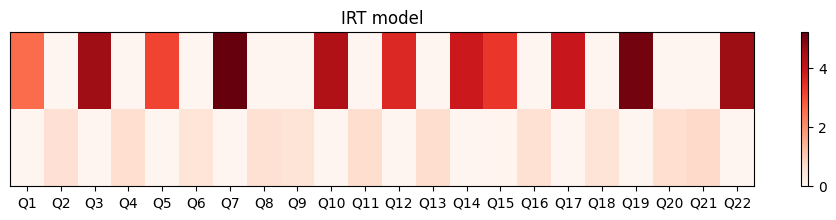

In [12]:
_ = plt.figure(figsize=(12, 2))
plt.pcolormesh(discrim_mean[0, ..., 0], vmin=0, cmap="Reds")
_ = plt.colorbar()
_ = plt.title("IRT model")
_ = plt.yticks([])
_ = plt.xticks(
    np.arange(grm.num_items) + 0.5, labels=[f"Q{j+1}" for j in range(grm.num_items)]
)

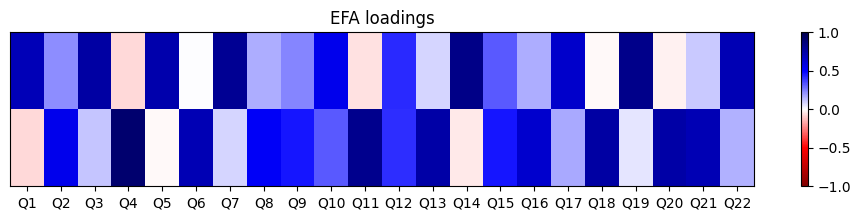

In [13]:
_ = plt.figure(figsize=(12, 2))

plt.pcolormesh(loadings.T, cmap="seismic_r", vmin=-1, vmax=1)
plt.colorbar()
_ = plt.yticks([])
_ = plt.xticks(
    np.arange(grm.num_items) + 0.5, labels=[f"Q{j+1}" for j in range(grm.num_items)]
)
_ = plt.title("EFA loadings")

In [14]:
scale_indices = [np.where(discrim_mean[0, ..., 0][0, :] > .5)[0].tolist()]
scale_indices += [[i for i in range(22) if i not in scale_indices[0]]]
scale_indices

[[1, 3, 5, 7, 8, 10, 12, 15, 17, 19, 20],
 [0, 2, 4, 6, 9, 11, 13, 14, 16, 18, 21]]

In [15]:
difficulties = tf.cumsum(
    tf.concat(
        [params['difficulties0'], params['ddifficulties']], axis=-1
    ), axis=-1
)

In [16]:
difficulties_mean = tf.reduce_mean(difficulties, axis=[0, 1])
difficulties_mean = tf.transpose(difficulties_mean, (1, 0, 2))
difficulties_mean.shape


TensorShape([22, 2, 8])

# Build fully factorized model

In [17]:
scale_indices

[[1, 3, 5, 7, 8, 10, 12, 15, 17, 19, 20],
 [0, 2, 4, 6, 9, 11, 13, 14, 16, 18, 21]]

In [18]:
fgrm = FactorizedGRModel(
    data=tfdata,
    item_keys=item_names,
    num_people=num_people,
    dim=dim,
    eta_scale=1e-3,
    kappa_scale=1e-3,
    weight_exponent=1,
    response_cardinality=9,
    scale_indices=scale_indices,
    discrimination_guess=tf.cast(np.abs(loadings).T, tf.float64)[tf.newaxis, :, :, tf.newaxis]
)

# Fit by projecting the original model

In [19]:
fgrm.fit_projection(grm, data_factory_factory(shuffle=True, repeat=True), num_steps=500)

Running optimization for 500 steps of 1 accumulated batches, checking every 1 steps
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/08e48859-48d1-45b1-8571-43a86f7c2f7f/08e48859-48d1-45b1-8571-43a86f7c2f7f-1


  0%|          | 0/500 [00:00<?, ?it/s]

Step 1: average-batch loss:0.5216333906500874 rel loss: inf
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/08e48859-48d1-45b1-8571-43a86f7c2f7f/08e48859-48d1-45b1-8571-43a86f7c2f7f-2


/Users/changjc/workspace/autoencirt/../bayesianquilts/bayesianquilts/util.py:248: RuntimeWarning: overflow encountered in scalar divide
  rel = np.abs(deviation / loss)
  0%|          | 1/500 [00:01<15:25,  1.85s/it]

Step 2: average-batch loss:0.5770581201188363 rel loss: 0.09604704887843014
New learning rate: 0.95


  0%|          | 2/500 [00:02<07:16,  1.14it/s]

Step 3: average-batch loss:0.5022008858983994 rel loss: 0.038694684333192134
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/08e48859-48d1-45b1-8571-43a86f7c2f7f/08e48859-48d1-45b1-8571-43a86f7c2f7f-3


  1%|          | 3/500 [00:02<04:39,  1.78it/s]

Step 4: average-batch loss:0.37764042819825305 rel loss: 0.3298387788998979
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/08e48859-48d1-45b1-8571-43a86f7c2f7f/08e48859-48d1-45b1-8571-43a86f7c2f7f-4


  1%|          | 4/500 [00:02<03:23,  2.43it/s]

Step 5: average-batch loss:0.3138495123487285 rel loss: 0.2032531940933666
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/08e48859-48d1-45b1-8571-43a86f7c2f7f/08e48859-48d1-45b1-8571-43a86f7c2f7f-5


  1%|          | 5/500 [00:02<02:43,  3.03it/s]

Step 6: average-batch loss:0.3506936387912075 rel loss: 0.10506072071759169
New learning rate: 0.9025


  1%|          | 6/500 [00:02<02:13,  3.69it/s]

Step 7: average-batch loss:0.35806747893969154 rel loss: 0.12349059658224527
New learning rate: 0.8573749999999999


  1%|▏         | 7/500 [00:02<01:54,  4.29it/s]

Step 8: average-batch loss:0.34181324687250214 rel loss: 0.08180997892748215
New learning rate: 0.8145062499999999


  2%|▏         | 8/500 [00:03<01:43,  4.75it/s]

Step 9: average-batch loss:0.31302513388878317 rel loss: 0.002633585519807549
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/08e48859-48d1-45b1-8571-43a86f7c2f7f/08e48859-48d1-45b1-8571-43a86f7c2f7f-6


  2%|▏         | 9/500 [00:03<01:40,  4.89it/s]

Step 10: average-batch loss:0.2850610197011339 rel loss: 0.09809869555987571
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/08e48859-48d1-45b1-8571-43a86f7c2f7f/08e48859-48d1-45b1-8571-43a86f7c2f7f-7


  2%|▏         | 10/500 [00:03<01:36,  5.09it/s]

Step 11: average-batch loss:0.3070477939771986 rel loss: 0.07160700942113739
New learning rate: 0.7737809374999998


  2%|▏         | 11/500 [00:03<01:29,  5.48it/s]

Step 12: average-batch loss:0.3132257212960191 rel loss: 0.08991822727185197
New learning rate: 0.7350918906249998


  2%|▏         | 12/500 [00:03<01:25,  5.72it/s]

Step 13: average-batch loss:0.3106311436078275 rel loss: 0.08231667826255035
New learning rate: 0.6983372960937497


  3%|▎         | 13/500 [00:03<01:21,  5.96it/s]

Step 14: average-batch loss:0.285726449684842 rel loss: 0.0023289057923831812
New learning rate: 0.6634204312890623


  3%|▎         | 14/500 [00:04<01:19,  6.11it/s]

Step 15: average-batch loss:0.26483250613576537 rel loss: 0.07638229105832825
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/08e48859-48d1-45b1-8571-43a86f7c2f7f/08e48859-48d1-45b1-8571-43a86f7c2f7f-8


  3%|▎         | 15/500 [00:04<01:22,  5.91it/s]

Step 16: average-batch loss:0.2611960224482163 rel loss: 0.0139224313351479
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/08e48859-48d1-45b1-8571-43a86f7c2f7f/08e48859-48d1-45b1-8571-43a86f7c2f7f-9


  3%|▎         | 16/500 [00:04<01:22,  5.86it/s]

Step 17: average-batch loss:0.2567203141047192 rel loss: 0.017434180692344623
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/08e48859-48d1-45b1-8571-43a86f7c2f7f/08e48859-48d1-45b1-8571-43a86f7c2f7f-10


  3%|▎         | 17/500 [00:04<01:21,  5.90it/s]

Step 18: average-batch loss:0.23039180552702462 rel loss: 0.11427710511434082
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/08e48859-48d1-45b1-8571-43a86f7c2f7f/08e48859-48d1-45b1-8571-43a86f7c2f7f-11


  4%|▎         | 18/500 [00:04<01:24,  5.72it/s]

Step 19: average-batch loss:0.27776778315166134 rel loss: 0.17055965629667502


  4%|▍         | 19/500 [00:04<01:19,  6.04it/s]

Terminating because the loss converged


  4%|▍         | 19/500 [00:05<02:08,  3.76it/s]


<tf.Tensor: shape=(19,), dtype=float64, numpy=
array([0.52163339, 0.57705812, 0.50220089, 0.37764043, 0.31384951,
       0.35069364, 0.35806748, 0.34181325, 0.31302513, 0.28506102,
       0.30704779, 0.31322572, 0.31063114, 0.28572645, 0.26483251,
       0.26119602, 0.25672031, 0.23039181, 0.27776778])>

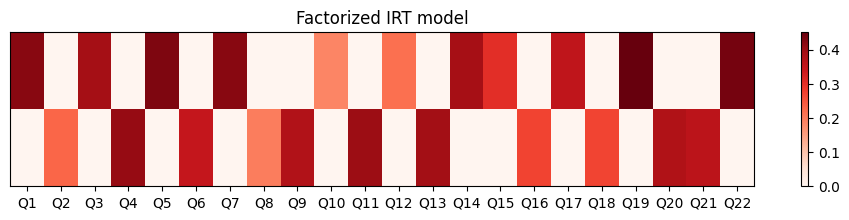

In [20]:
_ = plt.figure(figsize=(12, 2))

fparams = fgrm.sample(256)
fdiscrim = fparams['discriminations']
fdiscrim_mean = np.mean(fdiscrim, axis=0)
plt.pcolormesh(fdiscrim_mean[0, ..., 0], vmin=0, cmap='Reds')
_ = plt.colorbar()
_ = plt.title("Factorized IRT model")
_ = plt.yticks([])
_ = plt.xticks(
    np.arange(grm.num_items) + 0.5, labels=[f"Q{j+1}" for j in range(grm.num_items)]
)

In [21]:

fdifficulties = tf.cumsum(
    tf.concat(
        [fparams['difficulties0'], fparams['ddifficulties']], axis=-1
    ), axis=-1
)

fdifficulties_mean = tf.reduce_mean(fdifficulties, axis=[0, 1])
fdifficulties_mean = tf.transpose(fdifficulties_mean, (1, 0, 2))
fdifficulties_mean.shape


TensorShape([22, 2, 8])

In [22]:
item_text

['The established authorities generally turn out to be right about things, while the radicals and protestors are usually just "loud mouths" showing off their ignorance.',
 'Women should have to promise to obey their husbands when they get married.',
 'Our country desperately needs a mighty leader who will do what has to be done to destroy the radical new ways and sinfulness that are ruining us.',
 'Gays and lesbians are just as healthy and moral as anybody else.',
 "It is always better to trust the judgement of the proper authorities in government and religion than to listen to the noisy rabble-rousers in our society who are trying to create doubt in people's minds.",
 'Atheists and others who have rebelled against the established religions are no doubt every bit as good and virtuous as those who attend church regularly.',
 'The only way our country can get through the crisis ahead is to get back to our traditional values, put some tough leaders in power, and silence the troublemakers 

In [23]:
{name: text for j, (name, text) in enumerate(zip(item_names, item_text))}

{'Q1': 'The established authorities generally turn out to be right about things, while the radicals and protestors are usually just "loud mouths" showing off their ignorance.',
 'Q2': 'Women should have to promise to obey their husbands when they get married.',
 'Q3': 'Our country desperately needs a mighty leader who will do what has to be done to destroy the radical new ways and sinfulness that are ruining us.',
 'Q4': 'Gays and lesbians are just as healthy and moral as anybody else.',
 'Q5': "It is always better to trust the judgement of the proper authorities in government and religion than to listen to the noisy rabble-rousers in our society who are trying to create doubt in people's minds.",
 'Q6': 'Atheists and others who have rebelled against the established religions are no doubt every bit as good and virtuous as those who attend church regularly.',
 'Q7': 'The only way our country can get through the crisis ahead is to get back to our traditional values, put some tough leader

# create JSON

In [24]:
discrim_mean[0, ..., 0].T.tolist()[0]
scale_names = ['A', 'B']

In [25]:
responses = [
    "very strongly disagree",
    "strongly disagree",
    "moderately disagree",
    "slightly disagree",
    "feel neutral",
    "slightly agree",
    "moderately agree",
    "strongly agree",
    "very strongly agree",
]

mixed_model = [
    {
        "name": name,
        "question": text,
        "responses": {
            **{str(k + 1): {"text": r, "value": k + 1 if j not in to_reverse else 9-k} for k, r in enumerate(responses)},
            "0": {'text': 'skip', 'value': 0}
        },
        "scales": {
            scale_names[k]: {"discrimination": lam, 'difficulties': dif} for k, (lam, dif) in enumerate(zip(dis, diff))
        },
    }
    for j, (name, text, dis, diff) in enumerate(
        zip(item_names, item_text, discrim_mean[0, ..., 0].T.tolist(), difficulties_mean.numpy().tolist())
    )
]

mixed_model[0]

{'name': 'Q1',
 'question': 'The established authorities generally turn out to be right about things, while the radicals and protestors are usually just "loud mouths" showing off their ignorance.',
 'responses': {'1': {'text': 'very strongly disagree', 'value': 1},
  '2': {'text': 'strongly disagree', 'value': 2},
  '3': {'text': 'moderately disagree', 'value': 3},
  '4': {'text': 'slightly disagree', 'value': 4},
  '5': {'text': 'feel neutral', 'value': 5},
  '6': {'text': 'slightly agree', 'value': 6},
  '7': {'text': 'moderately agree', 'value': 7},
  '8': {'text': 'strongly agree', 'value': 8},
  '9': {'text': 'very strongly agree', 'value': 9},
  '0': {'text': 'skip', 'value': 0}},
 'scales': {'A': {'discrimination': 0.001989677781471193,
   'difficulties': [0.04676731191833739,
    0.8590733947810055,
    1.6652428918799254,
    2.4843189008673305,
    3.3055562984801163,
    4.139653477301024,
    4.949959935576636,
    5.752094861718265]},
  'B': {'discrimination': 2.5884160200

In [28]:
!pwd

/Users/changjc/workspace/autoencirt


In [26]:
factorized_model = [
    {
        "name": name,
        "question": text,
        "responses": {
            **{str(k + 1): {"text": r, "value": k + 1 if j not in to_reverse else 9-k} for k, r in enumerate(responses)},
            "0": {'text': 'skip', 'value': 0}
        },
        "scales": {
            scale_names[k]: {"discrimination": lam, 'difficulties': dif} for k, (lam, dif) in enumerate(zip(dis, diff)) if lam > 0
        },
    }
    for j, (name, text, dis, diff) in enumerate(
        zip(item_names, item_text, fdiscrim_mean[0, ..., 0].T.tolist(), fdifficulties_mean.numpy().tolist())
    )
]
factorized_model[0]

{'name': 'Q1',
 'question': 'The established authorities generally turn out to be right about things, while the radicals and protestors are usually just "loud mouths" showing off their ignorance.',
 'responses': {'1': {'text': 'very strongly disagree', 'value': 1},
  '2': {'text': 'strongly disagree', 'value': 2},
  '3': {'text': 'moderately disagree', 'value': 3},
  '4': {'text': 'slightly disagree', 'value': 4},
  '5': {'text': 'feel neutral', 'value': 5},
  '6': {'text': 'slightly agree', 'value': 6},
  '7': {'text': 'moderately agree', 'value': 7},
  '8': {'text': 'strongly agree', 'value': 8},
  '9': {'text': 'very strongly agree', 'value': 9},
  '0': {'text': 'skip', 'value': 0}},
 'scales': {'B': {'discrimination': 0.42070160978320503,
   'difficulties': [-3.1287935603188393,
    0.009203221746713678,
    2.2110445052354017,
    3.3545900861346407,
    4.809857037763789,
    6.207513059272409,
    8.44565386574049,
    10.590827677580418]}}}

In [33]:
for x in factorized_model:
    with open(f"RWAS/factorized/{x['name']}.json", 'w') as f:
        json.dump(x, f, indent=2)

In [34]:
for x in mixed_model:
    with open(f"RWAS/autoencoded/{x['name']}.json", 'w') as f:
        json.dump(x, f, indent=2)